In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob, os, sys
from pathlib import Path
import xarray as xr

from helpers.delphi_epidata import Epidata
import epiweeks

## Dataset format for my class:
The dataset is a xarray object stored as netcdf on disk. It has dimensions `(sample, feature, date, place)` where date and place are padded to have dimension 64.
- dates are Saturdays
- places are location from Flusight data locations
- samples are integers

```python
import torchvision.transforms.functional as TF
import random

def my_segmentation_transforms(image, segmentation):
    if random.random() > 0.5:
        angle = random.randint(-30, 30)
        image = TF.rotate(image, angle)
        segmentation = TF.rotate(segmentation, angle)
    # more transforms ...
    return image, segmentation
```

## FluSight dataset (= Ground-truth data)

Make sure my fork is synced, then
```bash
./update_data.sh
```
Locations are always ordered like this dataframe:

In [2]:
us_states = pd.read_csv("datasets/Flusight-forecast-data/data-locations/locations.csv")
us_states['geoid'] = us_states['location']+'000'
us_states = us_states.iloc[1:,:].reset_index(drop=True)  # skip first row, which is the US full
us_states

,abbreviation,location,location_name,population,geoid
0,AL,01,Alabama,4903185.0,01000
1,AK,02,Alaska,731545.0,02000
2,AZ,04,Arizona,7278717.0,04000
3,AR,05,Arkansas,3017804.0,05000
4,CA,06,California,39512223.0,06000
5,CO,08,Colorado,5758736.0,08000
6,CT,09,Connecticut,3565287.0,09000
7,DE,10,Delaware,973764.0,10000
8,DC,11,District of Columbia,705749.0,11000
9,FL,12,Florida,21477737.0,12000


In [3]:
def get_location_name(location):
    return us_states[us_states['location']==location]['location_name'].values[0]

In [4]:
hosp = pd.read_csv("datasets/Flusight-forecast-data/data-truth/truth-Incident Hospitalizations.csv", parse_dates=True, index_col='date')
hosp = hosp[hosp['location'].isin(us_states['location'])]

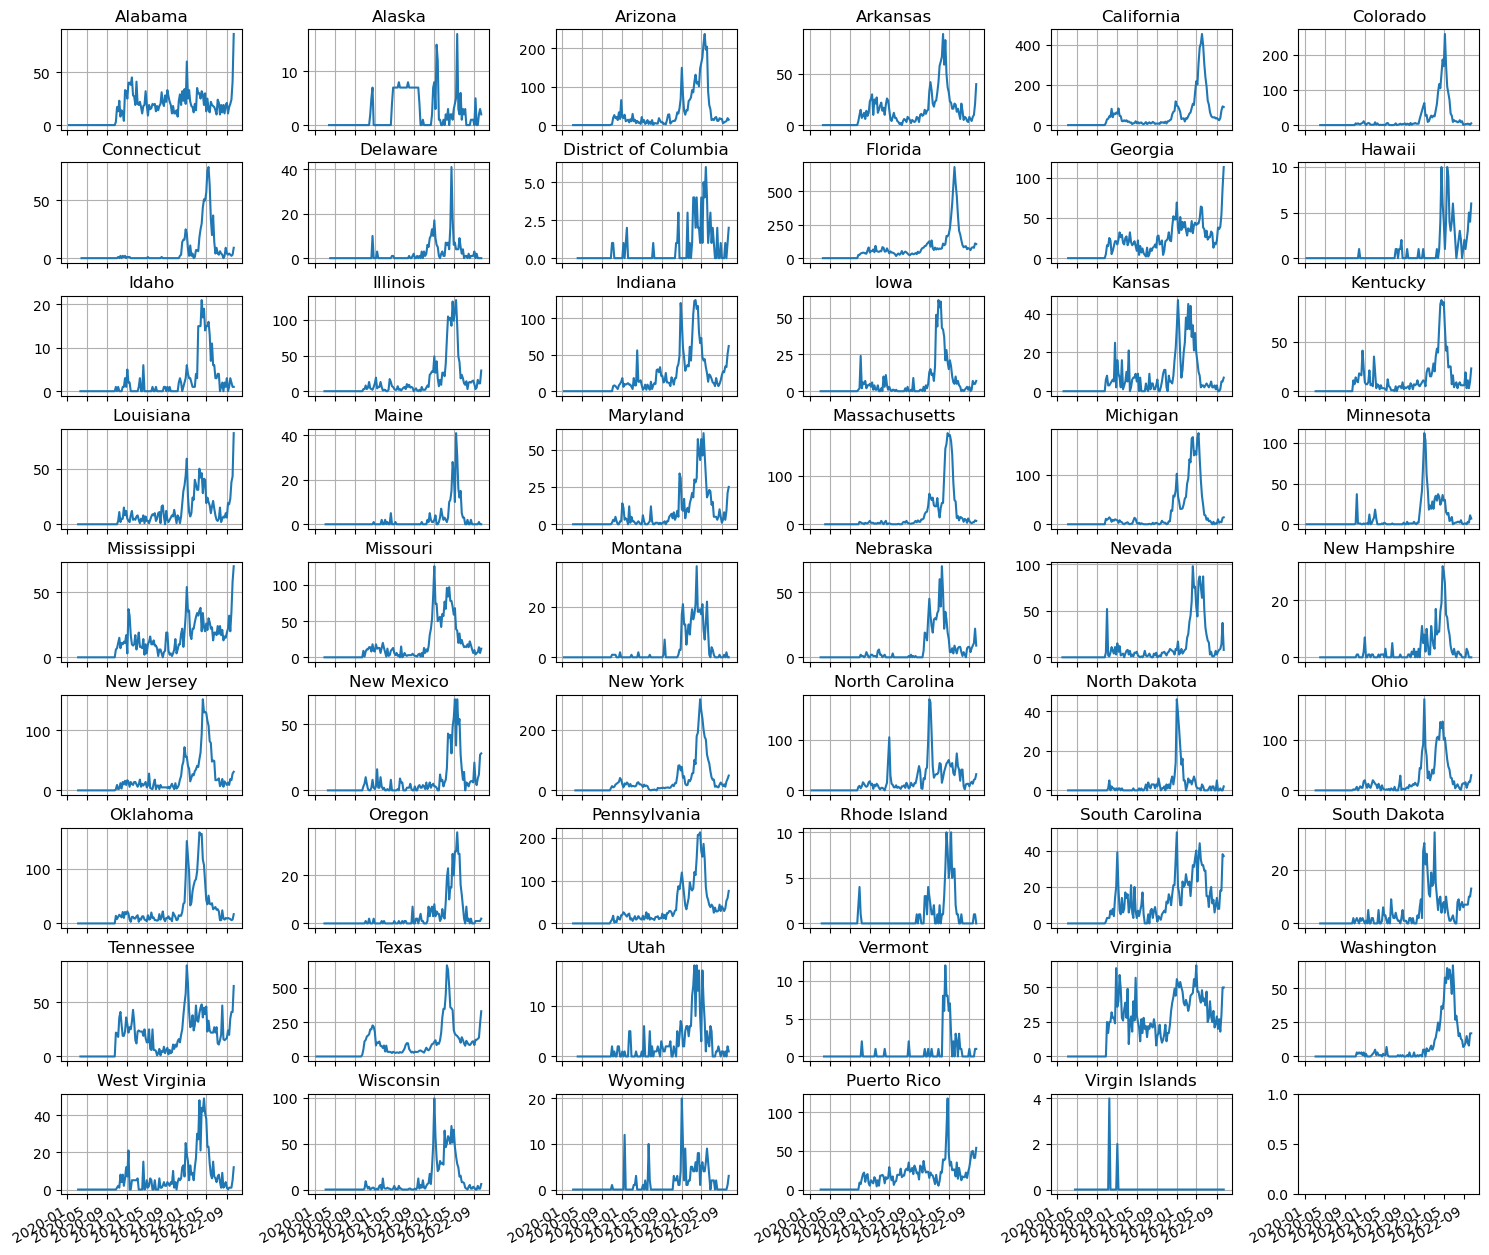

In [5]:
fig, axes = plt.subplots(9, 6, sharex=True, figsize=(15,15))
hosp_piv  = hosp.pivot(columns='location', values='value')
for idx, pl in enumerate(us_states["location"]):
    ax = axes.flat[idx]
    ax.plot(hosp_piv[pl])
    ax.set_title(get_location_name(pl))
    ax.grid()
fig.tight_layout()
fig.autofmt_xdate()

In [6]:
assert (hosp_piv.columns == us_states['location']).all() # make sure order is right

In [7]:
np.array([hosp_piv.to_numpy()]).shape

(1, 145, 53)

In [8]:
gt_xarr = xr.DataArray(np.array([hosp_piv.to_numpy()]),
            name = "gt_flusight_incidHosp",
            coords={'feature': ["incidHosp"], 'date': hosp_piv.index, 'place': us_states['location']}, 
            dims=["feature", "date", "place"])

print(gt_xarr.shape)
gt_xarr.to_netcdf(f"datasets/{gt_xarr.name}.nc")

(1, 145, 53)


This data is on saturday for 53 locations + US

## Delphi-epidata Flusurv

In [37]:
from turtle import down


def get_all_locations(dataset):
    if dataset == "flusurv":
        locations_fn = "datasets/delphi-epidata/labels/flusurv_locations.txt"
        locations = pd.read_csv(locations_fn, sep='\t', header=None, names=['location'])["location"].to_list()
    elif dataset=="fluview":
        import importlib  
        fluview_locations_m = importlib.import_module("datasets.delphi-epidata.src.acquisition.fluview.fluview_locations")
        fll_dict = fluview_locations_m.cdc_to_delphi
        locations = []
        for region_type in fll_dict.keys():
            for region_name, flloc in fll_dict[region_type].items():
                locations.append(flloc)
    return locations


def get_from_epidata(dataset, locations="all", write=True, download=True):
    if not download:
        return pd.read_csv(f"datasets/{dataset}.csv")
    
    # by location otherwise queries is too big
    df_list = []
    if locations == "all":
        locations = get_all_locations(dataset=dataset)

    for location in locations:
        if dataset == 'flusurv':
            res = Epidata.flusurv(location, [Epidata.range(190001, 202251)])  # large range to get all data
        elif dataset == "fluview":
            res = Epidata.fluview(location, [Epidata.range(190001, 202251)])  # large range to get all data
        if res['result'] == 1:
            flu_data_loc = pd.json_normalize(res['epidata'])
            print(f">> {location: <12} {res['result']}, {res['message']}, with {len(res['epidata']):4} data points from {flu_data_loc.epiweek.min()} to {flu_data_loc.epiweek.max()}")
            df_list.append(flu_data_loc)
        else:
            print(f"EE {location: <12} {res['result']}, {res['message']} !")
    
    df = pd.concat(df_list)

    df['week_enddate'] = df['epiweek'].astype(str).apply(lambda x: epiweeks.Week.fromstring(week_string=x, system="cdc").enddate())

    if write:
        df.to_csv(f"datasets/{dataset}.csv", index=False)

    return df


In [38]:
flusurv = get_from_epidata(dataset="flusurv")
flusurv

>> CA           1, success, with  518 data points from 200340 to 202017
>> CO           1, success, with  518 data points from 200340 to 202017
>> CT           1, success, with  518 data points from 200340 to 202017
>> GA           1, success, with  518 data points from 200340 to 202017
>> IA           1, success, with   65 data points from 200935 to 201317
>> ID           1, success, with   65 data points from 200935 to 201117
>> MD           1, success, with  518 data points from 200340 to 202017
>> MI           1, success, with  336 data points from 200935 to 202017
>> MN           1, success, with  518 data points from 200340 to 202017
>> NM           1, success, with  487 data points from 200440 to 202017
>> NY_albany    1, success, with  518 data points from 200340 to 202017
>> NY_rochester 1, success, with  518 data points from 200340 to 202017
>> OH           1, success, with  301 data points from 201040 to 202017
>> OK           1, success, with   65 data points from 200935 to

,release_date,location,issue,epiweek,lag,rate_age_0,rate_age_1,rate_age_2,rate_age_3,rate_age_4,rate_overall,week_enddate
0,2017-02-07,CA,201704,200340,695,0.0,0.0,NaN,NaN,NaN,0.0,2003-10-04
1,2017-02-07,CA,201704,200341,694,0.0,0.0,NaN,NaN,NaN,0.0,2003-10-11
2,2017-02-07,CA,201704,200342,693,0.0,0.0,NaN,NaN,NaN,0.0,2003-10-18
3,2017-02-07,CA,201704,200343,692,0.0,0.0,NaN,NaN,NaN,0.0,2003-10-25
4,2017-02-07,CA,201704,200344,691,0.0,0.6,NaN,NaN,NaN,0.5,2003-11-01
...,...,...,...,...,...,...,...,...,...,...,...,...
331,2021-05-28,network_ihsp,202111,202013,51,0.0,0.0,0.2,0.9,2.1,0.6,2020-03-28
332,2021-05-28,network_ihsp,202111,202014,50,0.3,0.0,0.2,0.0,0.5,0.2,2020-04-04
333,2021-05-28,network_ihsp,202111,202015,49,0.0,0.0,0.1,0.3,0.2,0.1,2020-04-11
334,2021-05-28,network_ihsp,202111,202016,48,0.0,0.0,0.0,0.1,0.2,0.0,2020-04-18


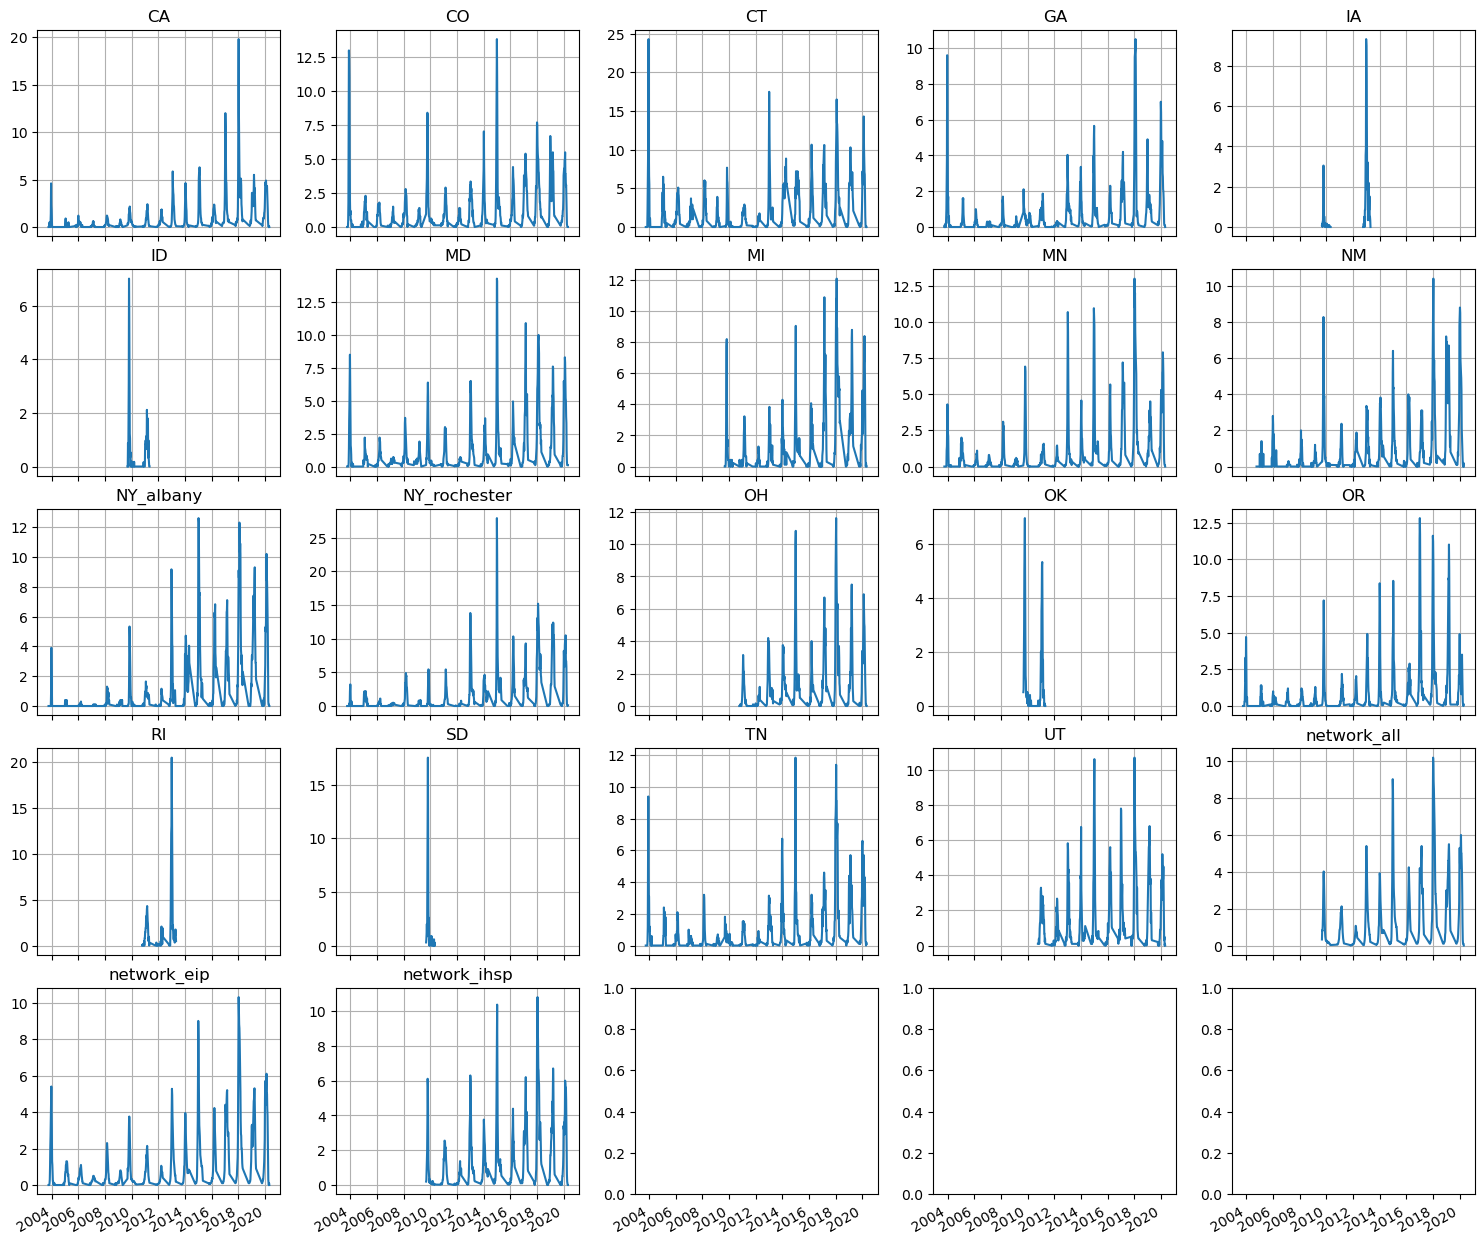

In [11]:
fig, axes = plt.subplots(5, 5, sharex=True, figsize=(15,15))
flusurv_piv  = flusurv.pivot(columns='location', values='rate_overall', index="week_enddate")
for idx, pl in enumerate(get_all_locations("flusurv")):
    ax = axes.flat[idx]
    ax.plot(flusurv_piv[pl])
    ax.set_title(pl)#get_location_name(pl))
    ax.grid()
fig.tight_layout()
fig.autofmt_xdate()

## Epidata Fluview
There is also [fluview clinical](https://cmu-delphi.github.io/delphi-epidata/api/fluview_clinical.html) for FluA, FluB, and tested specimen. Which quantity should I look for in this dataset ?

['nat', 'hhs1', 'hhs2', 'hhs3', 'hhs4', 'hhs5', 'hhs6', 'hhs7', 'hhs8', 'hhs9', 'hhs10', 'cen1', 'cen2', 'cen3', 'cen4', 'cen5', 'cen6', 'cen7', 'cen8', 'cen9', 'al', 'ak', 'az', 'ar', 'ca', 'co', 'ct', 'de', 'fl', 'ga', 'hi', 'id', 'il', 'in', 'ia', 'ks', 'ky', 'la', 'me', 'md', 'ma', 'mi', 'mn', 'ms', 'mo', 'mt', 'ne', 'nv', 'nh', 'nj', 'nm', 'ny_minus_jfk', 'nc', 'nd', 'oh', 'ok', 'or', 'pa', 'ri', 'sc', 'sd', 'tn', 'tx', 'ut', 'vt', 'va', 'wa', 'wv', 'wi', 'wy', 'as', 'mp', 'dc', 'gu', 'pr', 'vi', 'ord', 'lax', 'jfk']


In [40]:
fluview = get_from_epidata(dataset="fluview")
fluview

>> nat          1, success, with 1206 data points from 199740 to 202235
>> hhs1         1, success, with 1206 data points from 199740 to 202235
>> hhs2         1, success, with 1206 data points from 199740 to 202235
>> hhs3         1, success, with 1206 data points from 199740 to 202235
>> hhs4         1, success, with 1206 data points from 199740 to 202235
>> hhs5         1, success, with 1206 data points from 199740 to 202235
>> hhs6         1, success, with 1206 data points from 199740 to 202235
>> hhs7         1, success, with 1206 data points from 199740 to 202235
>> hhs8         1, success, with 1206 data points from 199740 to 202235
>> hhs9         1, success, with 1206 data points from 199740 to 202235
>> hhs10        1, success, with 1206 data points from 199740 to 202235
>> cen1         1, success, with 1206 data points from 199740 to 202235
>> cen2         1, success, with 1206 data points from 199740 to 202235
>> cen3         1, success, with 1206 data points from 199740 to

,release_date,region,issue,epiweek,lag,num_ili,num_patients,num_providers,num_age_0,num_age_1,num_age_2,num_age_3,num_age_4,num_age_5,wili,ili,week_enddate
0,2013-12-31,nat,201352,199740,847,570,46842,192,179,205,157.0,NaN,NaN,29,1.101483,1.216857,1997-10-04
1,2013-12-31,nat,201352,199741,846,615,48023,191,199,242,151.0,NaN,NaN,23,1.200068,1.280636,1997-10-11
2,2013-12-31,nat,201352,199742,845,681,54961,219,228,266,153.0,NaN,NaN,34,1.378763,1.239060,1997-10-18
3,2013-12-31,nat,201352,199743,844,653,57044,213,188,236,193.0,NaN,NaN,36,1.199199,1.144730,1997-10-25
4,2013-12-31,nat,201352,199744,843,700,55506,213,217,280,162.0,NaN,NaN,41,1.656178,1.261125,1997-11-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
617,2022-09-09,jfk,202235,202231,4,1517,79616,26,None,None,None,None,None,None,1.905400,1.905400,2022-08-06
618,2022-09-09,jfk,202235,202232,3,1377,78674,26,None,None,None,None,None,None,1.750260,1.750260,2022-08-13
619,2022-09-09,jfk,202235,202233,2,1384,76378,25,None,None,None,None,None,None,1.812040,1.812040,2022-08-20
620,2022-09-09,jfk,202235,202234,1,1227,76349,24,None,None,None,None,None,None,1.607090,1.607090,2022-08-27


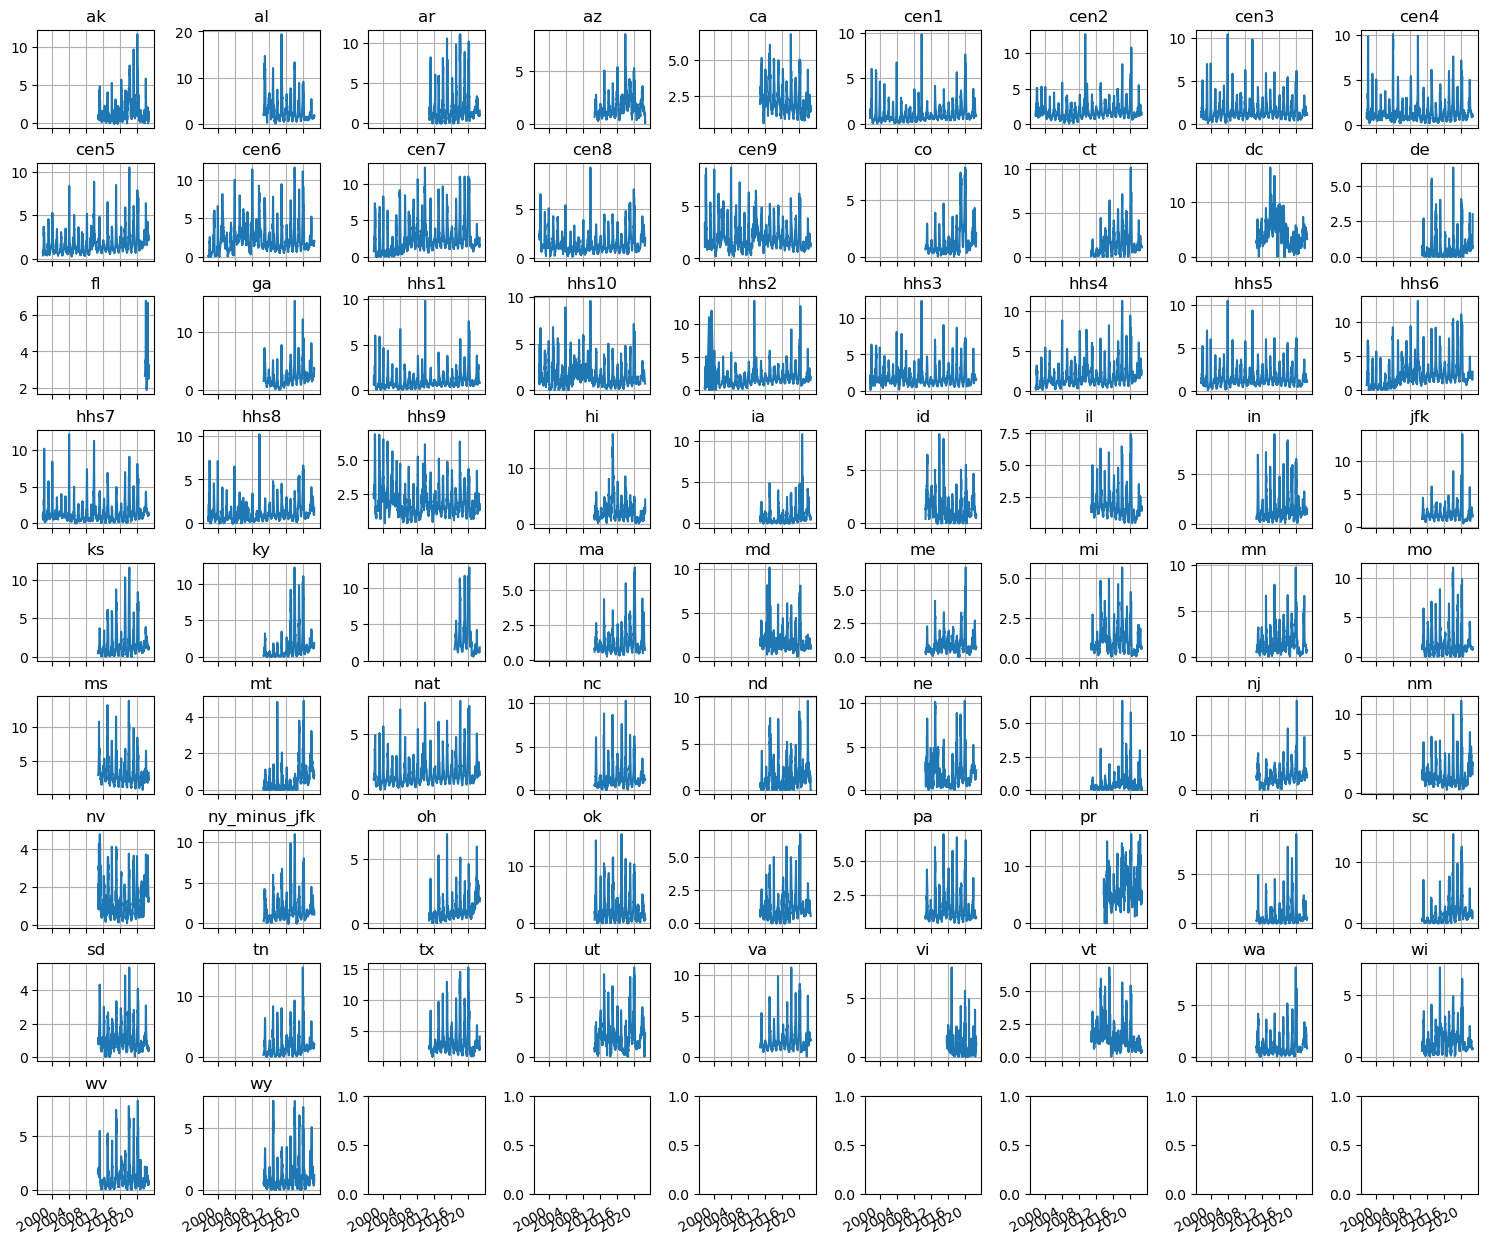

In [42]:
fig, axes = plt.subplots(9, 9, sharex=True, figsize=(15,15))
fluview_piv  = fluview.pivot(columns='region', values='ili', index="week_enddate")
for idx, pl in enumerate(fluview_piv.columns):
    ax = axes.flat[idx]
    ax.plot(fluview_piv[pl])
    ax.set_title(pl)#get_location_name(pl))
    ax.grid()
fig.tight_layout()
fig.autofmt_xdate()

## Synthetic dataset from CSP

In [ ]:
import gempyor
folder = 'datasets/SMH_R1/'
col2keep = ['incidH_FluA', 'incidH_FluB']

Commands to sync Flu SMH R1 from s3 bucket
```bash
aws s3 sync s3://idd-inference-runs/USA-20220923T154311/model_output/ datasets/SMH_R1/SMH_R1_lowVac_optImm_2022 --exclude "*" --include "hosp*/final/*"
aws s3 sync s3://idd-inference-runs/USA-20220923T155228/model_output/ datasets/SMH_R1/SMH_R1_lowVac_pesImm_2022 --exclude "*" --include "hosp*/final/*"
aws s3 sync s3://idd-inference-runs/USA-20220923T160106/model_output/ datasets/SMH_R1/SMH_R1_highVac_optImm_2022 --exclude "*" --include "hosp*/final/*"
aws s3 sync s3://idd-inference-runs/USA-20220923T161418/model_output/ datasets/SMH_R1/SMH_R1_highVac_pesImm_2022 --exclude "*" --include "hosp*/final/*"
```
and take a humidity file from the config


In [ ]:
humid = pd.read_csv('datasets/SMH_R1/SMH_R1_lowVac_optImm_2022/r0s_ts_2022-2023.csv', index_col='date', parse_dates=True)

In [ ]:
maxfiles = -1
hosp_files = list(Path(str(folder)).rglob('*.parquet'))[:maxfiles]
df = gempyor.read_df(str(hosp_files[0]))

# To be pasted later
indexes = df[['date', 'geoid']]
full_df = df[['date', 'geoid']] # to
geoids = list(pd.concat([df[col2keep[0]], indexes], axis=1).pivot(values=col2keep[0], index='date', columns='geoid').columns)
dates = list(pd.concat([df[col2keep[0]], indexes], axis=1).pivot(values=col2keep[0], index='date', columns='geoid').index)

In [ ]:
df.columns

Index(['date', 'geoid', 'incidI_1dose_FluA_age0to4_R1',
       'incidI_1dose_FluB_age0to4_R1', 'incidI_unvaccinated_FluA_age0to4_R1',
       'incidI_unvaccinated_FluB_age0to4_R1', 'incidI_waned_FluA_age0to4_R1',
       'incidI_waned_FluB_age0to4_R1', 'incidI_1dose_FluA_age18to49_R1',
       'incidI_1dose_FluB_age18to49_R1',
       ...
       'incidD_1dose_FluA_age65to100_R1', 'incidD_1dose_FluB_age65to100_R1',
       'incidD_unvaccinated_FluA_age65to100_R1',
       'incidD_unvaccinated_FluB_age65to100_R1',
       'incidD_waned_FluA_age65to100_R1', 'incidD_waned_FluB_age65to100_R1',
       'incidD_FluA', 'incidD_FluB', 'incidD', 'time'],
      dtype='object', length=135)

In [ ]:
incid_xarr = xr.DataArray(-1 * np.ones((len(hosp_files), 
                           len(col2keep),
                           len(full_df.date.unique()),
                           len(full_df.geoid.unique())
                          )), 
                         coords={'sample': np.arange(len(hosp_files)),'feature': col2keep, 'date': dates, 'place': geoids}, 
                         dims=["sample", "feature", "date", "place"])


for i, path_str in enumerate(hosp_files):
    df = gempyor.read_df(str(path_str))
    data = df[col2keep]
    for k, c in enumerate(col2keep):
        incid_xarr.loc[dict(sample=i, feature=c)] = pd.concat([data[c], indexes], axis=1).pivot(values=c, index='date', columns='geoid').to_numpy()
        

    data.columns = [n+f'_{i}' for n in col2keep]   
    full_df = pd.concat([full_df, data], axis=1)
    

print(int((incid_xarr<0).sum()), f' errors on {i} files')

0  errors on 1198 files


In [ ]:
humid_st = np.dstack([humid.to_numpy()]*len(hosp_files))
#humid_st = humid_st[:, np.newaxis, :]
print(humid_st.shape)
covar_xarr = xr.DataArray(humid_st, 
                          coords={
                                  #'feature': ['R0Humidity'],
                                  'date': humid.index,
                                  'place': geoids,
                                  'sample': np.arange(len(hosp_files)),}, 
                          dims=[ "date", "place", "sample"]) #"feature",
covar_xarr = covar_xarr.expand_dims({"feature":['R0Humidity']})

(329, 51, 1199)


### makes the dates of r0 and humidity match

In [ ]:
print(type(incid_xarr), incid_xarr.date[0], incid_xarr.date[-1] )
print(type(covar_xarr), covar_xarr.date[0], covar_xarr.date[-1])

<class 'xarray.core.dataarray.DataArray'> <xarray.DataArray 'date' ()>
array('2022-07-24T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    date     datetime64[ns] 2022-07-24 <xarray.DataArray 'date' ()>
array('2023-08-05T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    date     datetime64[ns] 2023-08-05
<class 'xarray.core.dataarray.DataArray'> <xarray.DataArray 'date' ()>
array('2022-07-17T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    date     datetime64[ns] 2022-07-17 <xarray.DataArray 'date' ()>
array('2023-06-10T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    date     datetime64[ns] 2023-06-10


In [ ]:
full_xarr = xr.concat([incid_xarr,covar_xarr], dim="feature", join="inner")

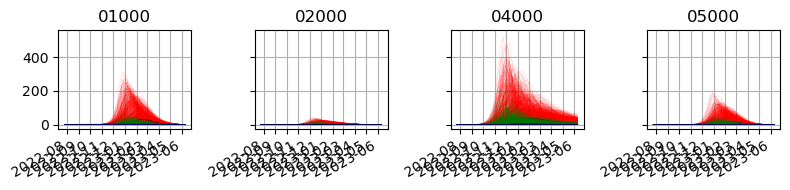

In [ ]:
grid = (1,4)
fig, axes = plt.subplots(grid[0], grid[1], sharex=True, sharey=True, figsize=(grid[1]*2,grid[0]*2))
for i, ax in enumerate(axes.flat):
    c = ['red', 'green', 'blue']
    place = full_xarr.get_index('place')[i]
    tp = full_xarr.sel(place=place)
    for k, val in enumerate(full_xarr.feature):
        ax.plot(tp.date, tp.sel(feature=val).T, c = c[k], lw = .1, alpha=.5)
        ax.plot(tp.date, tp.sel(feature=val).T.median(axis=1), 
                c = 'k',#'dark'+c[k], 
                lw = .5, 
                alpha=1)
    ax.grid()
    ax.set_title(place)
fig.autofmt_xdate()
fig.tight_layout()

In [ ]:
full_xarr_w = full_xarr.resample(date="W").sum()
full_xarr_w

In [ ]:
full_xarr_w_padded = full_xarr_w.pad({'date': (0, 17), 'place':(0,13)}, mode='constant', constant_values=0)
print(full_xarr_w_padded.shape)
full_xarr_w_padded.to_netcdf("datasets/synthetic/CSP_FluSMHR1_weekly_padded_4scn.nc")

## Dengue Trial

```python
def yw2date(row):
    year = int(row["year"])
    week = int(row["week"])
    date = "{}-{}-1".format(year, week)
    return datetime.strptime(date, "%Y-%W-%w")
df = pd.read_csv('dengue-thailand-province-week.csv')
df['year'] = df['date_sick_year']
df = df.drop('date_sick_year', axis=1)
df['date'] = df.apply(yw2date, axis=1)

## Cannot pivot there are duplicated entries:
df1 = df.set_index(['year', 'week', 'province'])
duplicated = np.where(df1.index.duplicated())
print(len(duplicated[0]), "duplicated index entries...")
print(duplicated[0])
print(df1.iloc[116065])
print(df1.loc[1999, 1, 10])

# pivot_table with aggregrate as mean
df = df.pivot_table(index='date', columns='province', values='cases', aggfunc='mean') # perhaps should be sum
fig, axes = plt.subplots(11, 7, sharex=True, sharey=True, figsize=(10,10))
for i, prov in enumerate(df.columns):
    ax = axes.flat[i]
    ax.plot(df[prov])
    ax.grid()
    ax.set_title(prov)
fig.autofmt_xdate()
fig.tight_layout()
```